# Зависимости

In [ ]:
!pip install --upgrade razdel spacy networkx seaborn scipy
!python -m spacy download ru_core_news_md

2024-01-14 18:49:10.252768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 18:49:10.252838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 18:49:10.254724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 18:49:10.266060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 18:49:12.689374: W tensorflow/compiler/tf2

In [ ]:
!python --version

Python 3.10.12


# Набор данных

Для тестирования будем использовать набор данных Gazeta: https://huggingface.co/datasets/IlyaGusev/gazeta


In [ ]:
# from datasets import load_dataset

# dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")["test"]

In [ ]:
# # Смотрим, как выглядят данные.
# dataset[0]

# Предобработка

In [ ]:
import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
# text = dataset[0]["text"]
# sentences = sentenize(text)
# print(tokenize_sentence(sentences[0]))
# print(tokenize_text(text))

## TextRank

In [ ]:
import math
import numpy as np
import networkx as nx
import seaborn as sns
from scipy.linalg import eig
from matplotlib import pyplot as plt


def text_rank_preprocessing(sentence):
    return tokenize_sentence(sentence)


def text_rank_similarity(tokens1, tokens2):
    intersection_size = sum(tokens2.count(w) for w in tokens1)
    if intersection_size == 0:
        return 0.0

    if len(tokens1) <= 1 and len(tokens2) <= 1:
        return intersection_size

    assert len(tokens1) > 0 and len(tokens2) > 0
    norm = math.log(len(tokens1)) + math.log(len(tokens2))
    return intersection_size / norm


class TextRankSummarizer:
    """
    TextRank.
    Основано на: https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/text_rank.py
    Оригинальная статья: https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf
    """

    def __init__(
        self,
        damping = 0.85,
        epsilon = 1e-4,
        niter = 100,
        preprocessing_function = text_rank_preprocessing,
        similarity_function = text_rank_similarity,
        verbose=False
    ):
        self.damping = damping
        self.epsilon = epsilon
        self.niter = niter
        self.preprocessing_function = preprocessing_function
        self.similarity_function = similarity_function
        self.threshold = None
        self.verbose = True

    def __call__(self, text, target_sentences_count):
        original_sentences = sentenize(text)
        sentences = [self.preprocessing_function(s) for s in original_sentences]

        graph = self._create_graph(sentences)
        graph = self._apply_threshold(graph)
        if self.verbose:
            plt.figure(figsize=(15,10))
            sns.heatmap(graph, annot=True, fmt=".2f").set_title("Матрица схожести предложений")
        norm_graph = self._norm_graph(graph)
        ranks = self._iterate(norm_graph)

        if self.verbose:
            print("Значимости: {}".format(ranks))

            # Можно считать PageRank библиотечными методами.
            # При запуске на оригинальном графе должно быть то же самое.
            nx_graph = nx.from_numpy_array(graph)
            indices = list(range(len(sentences)))
            nx_ranks = nx.pagerank(nx_graph)
            nx_ranks = [ranks[i] for i in indices]
            assert np.all(np.isclose(nx_ranks, ranks))
            print("Проверка через NetworkX в порядке!")

            # Можно считать через честный метод степенных итераций над
            # модифицированной матрицей. Должно быть то же самое.
            random_transitions = np.full(graph.shape, 1.0 / len(graph))
            full_matrix = (1.0 - self.damping) * random_transitions + self.damping * norm_graph
            pm_ranks = self._power_method(full_matrix)
            assert np.all(np.isclose(pm_ranks, ranks))
            assert np.all(np.isclose(np.dot(full_matrix.T, pm_ranks), pm_ranks, atol=self.epsilon))
            print("Проверка через метод степенных итераций в порядке!")

            # А ещё можно через собственные вектора.
            # Только они могут отличаться на константный множитель из-за нормировки.
            vals, vecs = eig(full_matrix.T, left=False, right=True)
            eig_ranks = vecs[:, vals.argmax()]
            assert np.all(np.isclose(np.dot(full_matrix.T, eig_ranks), eig_ranks, atol=self.epsilon))
            multiplier = ranks[0] / eig_ranks[0]
            eig_ranks *= multiplier
            assert np.all(np.isclose(eig_ranks, ranks, atol=self.epsilon * 100))
            print("Проверка через собственные вектора в порядке!")

        indices = list(range(len(sentences)))
        indices = [idx for _, idx in sorted(zip(ranks, indices), reverse=True)]
        indices = indices[:target_sentences_count]
        indices.sort()
        return " ".join([original_sentences[idx] for idx in indices])

    def set_sim_function(self, func):
        self.similarity_function = func

    def set_preprocessing_function(self, func):
        self.preprocessing_function = func

    def set_threshold(self, threshold):
        self.threshold = threshold

    def _create_graph(self, sentences):
        """ Сборка изначального графа схожостей """
        sentences_count = len(sentences)
        graph = np.zeros((sentences_count, sentences_count))
        for sentence_num1, sentence1 in enumerate(sentences):
            for sentence_num2 in range(sentence_num1, sentences_count):
                sentence2 = sentences[sentence_num2]
                sim = self.similarity_function(sentence1, sentence2)
                graph[sentence_num1, sentence_num2] = sim
                graph[sentence_num2, sentence_num1] = sim
        return graph

    def _apply_threshold(self, graph):
        """ Обрезка графа по порогу, понадобится в LexRank """
        if self.threshold is None:
            return graph
        graph[graph < self.threshold] = 0.0
        return graph

    def _norm_graph(self, graph):
        """
        Нормировка по строкам, потому что ниже p_vector - вектор, а не столбец.
        Если бы p_vector был столбцом, надо было бы нормировать по столбцам.
        """
        norm = graph.sum(axis=1)[:, np.newaxis]
        norm_graph = graph / (norm + 1e-7)
        assert np.isclose(np.sum(norm_graph[0, :]), 1.0)
        assert np.all(np.isclose(norm_graph.sum(axis=1), np.ones((graph.shape[0], ))))
        return norm_graph

    def _iterate(self, matrix):
        sentences_count = len(matrix)
        iter = 0
        lambda_val = 0.1
        p_vector = np.full((sentences_count, ), 1.0 / sentences_count)
        random_transitions = np.full((sentences_count, ), 1.0 / sentences_count)

        transposed_matrix = matrix.T
        while iter < self.niter and lambda_val > self.epsilon:
            next_p = (1.0 - self.damping) * random_transitions + self.damping * np.dot(transposed_matrix, p_vector)
            lambda_val = np.linalg.norm(np.subtract(next_p, p_vector))
            p_vector = next_p
            iter += 1
        return p_vector

    def _power_method(self, matrix):
        sentences_count = len(matrix)
        iter = 0
        lambda_val = 0.1
        p_vector = np.full((sentences_count, ), 1.0 / sentences_count)

        transposed_matrix = matrix.T
        while iter < self.niter and lambda_val > self.epsilon:
            next_p = np.dot(transposed_matrix, p_vector)
            lambda_val = np.linalg.norm(np.subtract(next_p, p_vector))
            p_vector = next_p
            iter += 1
        return p_vector

Значимости: [0.03015978 0.02078776 0.02316906 0.0190746  0.01333632 0.01496929
 0.01558038 0.01967112 0.01410836 0.01221285 0.02275752 0.01644117
 0.01738869 0.0250859  0.01597527 0.02551601 0.01259058 0.01593878
 0.01673341 0.01360995 0.01642901 0.02232147 0.01042781 0.02179333
 0.03256104 0.01943816 0.01443881 0.02205528 0.01756419 0.02826217
 0.01997136 0.01085859 0.02186094 0.01154835 0.02121985 0.01908626
 0.01556486 0.01229079 0.0171129  0.02104522 0.02169345 0.02196662
 0.01162055 0.01797343 0.017177   0.01682624 0.01938764 0.01750042
 0.02447113 0.02875909 0.01422129 0.01851851 0.01572662 0.01320076]
Проверка через NetworkX в порядке!
Проверка через метод степенных итераций в порядке!
Проверка через собственные вектора в порядке!

Итоговый реферат: Российские фондовые индикаторы сохранили оптимизм в среду, 10 января, поднявшись до максимума с конца ноября 2023 г. Инвестиционный энтузиазм подпитывается ростом цен на нефть, а также положительными корпоративными анонсами ведущих к

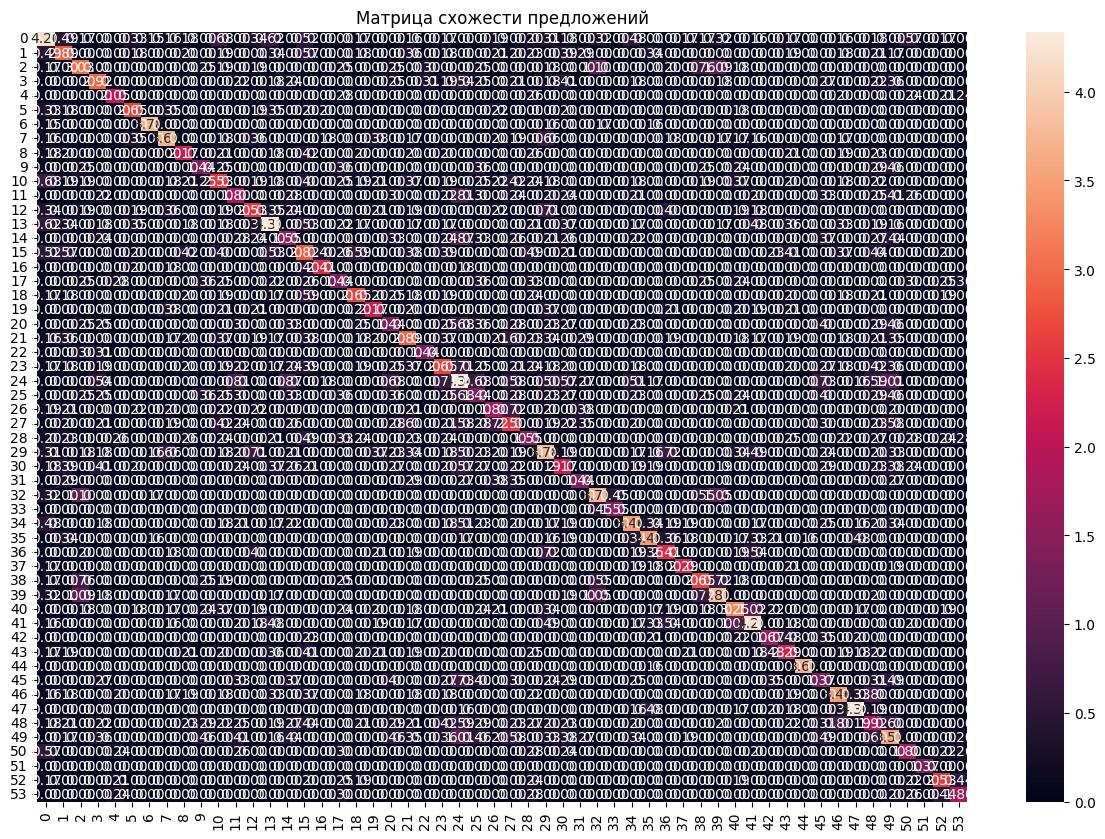

In [ ]:
text_rank = TextRankSummarizer(verbose=False)
summary = text_rank(text, 3)
print()
print("Итоговый реферат: {}".format(summary))

## TextRank на Трансформерах

In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tf_text

DEFAULT_ENCODER_PATH = "https://tfhub.dev/google/LaBSE/2"
DEFAULT_PREPROCESSOR_PATH = "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"


def gen_batch(records, batch_size):
    batch_start = 0
    while batch_start < len(records):
        batch_end = batch_start + batch_size
        batch = records[batch_start: batch_end]
        batch_start = batch_end
        yield batch


class LaBSE:
    """
    Класс, инкапсулирующий подсчёт LaBSE эмбеддингов
    """
    def __init__(self, encoder_path=DEFAULT_ENCODER_PATH, preprocessor_path=DEFAULT_PREPROCESSOR_PATH):
        self.preprocessor = hub.KerasLayer(preprocessor_path)
        self.model = hub.KerasLayer(encoder_path)

    def embed_batch(self, texts):
        def normalization(embeds):
            norms = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
            return embeds / norms
        return normalization(self.model(self.preprocessor(texts))["default"])

    def labse_get_embeddings(self, sentences, batch_size):
        embeddings = np.zeros((len(sentences), 768))
        current_index = 0
        for batch in gen_batch(sentences, batch_size):
            batch_embeddings = self.embed_batch(batch)
            embeddings[current_index:current_index+batch_size, :] = batch_embeddings
            current_index += batch_size
        return embeddings

    def __call__(self, sentences, batch_size=16):
        return self.labse_get_embeddings(sentences, batch_size)

In [ ]:
from scipy.spatial.distance import cosine

class LaBSETextRankSummarizer(TextRankSummarizer):
    """
    TextRank на LaBSE.
    """

    def __init__(self, *args, **kwagrs):
        super().__init__(*args, **kwagrs)

        self.labse = LaBSE()
        self.set_preprocessing_function(lambda x: self._labse_preprocessing_function(x))
        self.set_sim_function(lambda x1, x2: self._labse_similarity_function(x1, x2))

    def _labse_preprocessing_function(self, sentence):
        return self.labse([sentence])[0]

    def _labse_similarity_function(self, embedding1, embedding2):
        return max(1.0 - cosine(embedding1, embedding2), 0.0)

    def __call__(self, text, target_sentences_count):
        return super().__call__(text, target_sentences_count)

In [ ]:
text = '''
Российские фондовые индикаторы сохранили оптимизм в среду, 10 января, поднявшись до максимума с конца ноября 2023 г. Инвестиционный энтузиазм подпитывается ростом цен на нефть, а также положительными корпоративными анонсами ведущих компаний, входящих в состав индекса Московской биржи. Российские инвесторы ожидают новостей о дивидендах и с осторожным оптимизмом отслеживают перспективы возобновления дивидендных выплат от компаний, прошедших процедуру редомициляции.
По итогам сессии индекс МосБиржи вырос на 0,3% до 3164,7 пункта, долларовый РТС укрепился на 0,9% до 1115,5 пунктов.
В лидерах рынка можно выделить акции «Газпромнефти» (+2,7%), «Селигдара» (+2,4%), расписки «Озона» (+2,4%) и «GlobalTrans» (+2,2%). В «красной» зоне закрылись бумаги «Мечела» (ао -2,0%, ап -2,5%), «ТМК» (-1,2%), «Сегежи» (-2,7%), «Распадской» (-1,1%) и «Самолета» (-1,0%).
Российская нефтедобыча столкнулась с новым вызовом, поскольку последние партии нефти с проекта «Сахалин-1» задерживаются на пути к своим заказчикам. По информации «Коммерсантъ» со ссылкой на Kpler, с начала января танкер Vostochny Prospect остается неподвижным в районе Сингапура, а суда Jaguar, NS Lion и La Balena испытывают аналогичные трудности, фактически застряв в Южно-Китайском море.
В 2023 году грузооборот по Северному морскому пути достиг новых высот, превысив запланированные «Росатомом» показатели и составив 36,2 млн т — на 0,25 млн т больше ожидаемого. Существенную часть этого потока, а именно свыше 50%, занимает сжиженный природный газ от компании «Новатэк». Капитализация «Новатэка» выросла на 1,5%.
Объем торгов «Московской биржи» в 2023 г. вырос до рекордных 1,3 квадриллиона руб. (+24% г/г), сообщила компания. Тем не менее акции незначительно потеряли в стоимости, подешевев на скромные 0,07%.
«Транснефть» выпустила пресс-релиз, подводя итоги работы в области транспортировки нефти и нефтепродуктов в 2023 году. Компания отметила рост экспорта нефтепродуктов на 12,5% и повышение их прокачки на внутреннем рынке на 8%, в то время как экспорт российской нефти сократился на 6,5% при увеличении поставок на внутренние нефтеперерабатывающие заводы на 2,3%. Привилегированные акции «Транснефти» снизились на 0,1%.
Компания Softline расширила свой портфель активов, приобретя российскую компанию-разработчика платежных терминалов «Инверсум». Планируется совместный выпуск новой серии платежных терминалов на основе отечественного оборудования и программного обеспечения. Бумаги Softline выросли на 2,3%.
«Северсталь» укрепила свои позиции, приобретя две компании холдинга «Венталл» и производственный комплекс в Череповце, специализирующийся на изготовлении металлоконструкций. Данная сделка позволит достигнуть производственного объема в 126 тыс. тонн в год. Акции «Северстали» увеличились на 0,9%.
Ритейлер Fix Price получил разрешение на перевод дивидендов за 2022 год в размере 9,8 млрд руб. в материнскую кипрскую компанию. Расписки укрепились на 3%.
Внеочередное собрание акционеров «МГКЛ», материнской компании группы «Мосгорломбард», приняло решение о конвертации привилегированных акций в обыкновенные. Привилегированные акции составляют 23,91% уставного капитала, что представлено 27340 акциями по номиналу 100 рублей каждая, и планируется их дробление перед конвертацией для уравнивания стоимости с обыкновенными акциями. Акции «Мосгорломбарда» выросли на 2,6%.
Сегодня «Роснефть» и «Магнит» последний день торгуются с дивидендами за 9М 2023. Дивиденды «Роснефти» и «Магнита» составят 30,77 руб. и 412,13 руб. на акцию, соответственно. Бумаги компаний подорожали на 0,2% и 1,4%, соответственно.
Акции «ЛУКОЙЛа» показали прирост на 0,6% накануне заседания совета директоров, запланированного на 11 января, на котором будут определены стратегические задачи на 2024 год и подведены итоги 2023 года.
Инвесторам, интересующимся российским рынком акций, мы по традиции рекомендуем обратить внимание на стратегию «RU. Капитал и дивиденды».
Индекс Мосбиржи
С точки зрения теханализа индекс Мосбиржи движется в рамках восходящего канала с ближайшим уровнем поддержки в районе 3140 пунктов. Не исключается коррекция к данному уровню поддержки.
Фондовая Америка находится в ожидании декабрьских данных об инфляции
На американских биржах акции демонстрируют умеренный рост в преддверии публикации ключевых экономических данных. Инвесторы с напряжением ожидают четверга, когда будет раскрыта информация о декабрьской инфляции в США, что может стать определяющим фактором для будущих действий Федеральной резервной системы по ставкам. По итогам декабрьского заседания Федрезерв, напомним, спрогнозировал снижение ставки в следующем году не менее трех раз. Эксперты предполагают ускорение инфляции в Штатах в декабре до 3,2% в годовом выражении с 3,1% в ноябре.
По состоянию на 18:45 МСК индекс «голубых фишек» Dow Jones Industrial Average вырос на 0,23% до 37 609,9 пункта. Индекс широкого рынка Standard & Poor's 500 увеличивается на 0,25% до 4 768,2 пункта, а индекс высокотехнологичных отраслей Nasdaq Composite – на 0,39% до 14 916,1 пункта.
По сообщению Ассоциации ипотечных банкиров, число заявок на ипотечные кредиты в США за последнюю неделю выросло рекордными темпами за год – на 9,9%. В то же время первая неделя 2024 года принесла повышение средней процентной ставки по 30-летним ипотечным кредитам на 5 б.п., продолжив тем самым динамику роста ставок на вторую неделю подряд.
Walmart планирует расширить доставку дронами в США. К настоящему времени дронами компании было успешно выполнено 20 тыс. доставок в семи штатах страны. Альтернативой традиционным покупкам стал и запуск инновационного сервиса подписки InHome Replenishment, благодаря которому потребители смогут автоматически пополнять запасы скоропортящихся продуктов, руководствуясь анализом их предпочтений, обработанным искусственным интеллектом. Акции Walmart дорожают на 1%.
Глава Boeing Дэвид Кэлхун признал ошибку компании после того, как дверь одного из самолетов модели Boeing 737 MAX 9 отсоединилась на высоте 5 км. Ранее этот серьезный инцидент побудил Федеральное управление гражданской авиации США (FAA) приостановить полеты данного типа воздушных судов по всему воздушному пространству страны, а также их использование американскими авиалиниями, что затронуло 171 авиалайнер Boeing. С учетом выступления главы компании акции Boeing увеличиваются на 1,5%.
После объявления об увеличении годовых дивидендов на 33%, с $1,5 до $2 на акцию, и расширении программы выкупа акций на дополнительные $5 млрд рыночная капитализация строительного гиганта Lennar существенно подскочила – на 3,4%.
Между тем цена бумаг Apple, входящих в состав стратегии «US. Сбалансированная», проседает на 0,4%.
* Сообщение носит информационный характер, не является индивидуальной инвестиционной рекомендацией или предложением приобрести упомянутые ценные бумаги. Приобретение иностранных ценных бумаг связано с дополнительными рисками.
'''

In [ ]:

labse_rank = LaBSETextRankSummarizer(verbose=False)
summary = labse_rank(text, 5)
print()
print("Итоговый реферат: {}".format(summary))